# American and Bermudan Option pricer

In [1]:
# Packages used
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
from helper import GBM_Euler, value_option_schwarz, value_option_schwarz_test, value_option_bermudan
import keras

## Simulations Run with Data from paper

American option should be priced at .1144

In [2]:
# Parameters
K=1.1; M=4; r=.06; realizations=8

# Matrix
path_matrix = np.array([
[1.00, 1.09, 1.08, 1.34],
[1.00, 1.16, 1.26, 1.54],
[1.00, 1.22, 1.07, 1.03],
[1.00, 0.93, 0.97, 0.92],
[1.00, 1.11, 1.56, 1.52],
[1.00, .76, 0.77, 0.90],
[1.00, 0.92, 0.84, 1.01],
[1.00, 0.88, 1.22, 1.34]])

In [3]:
# Generate cash flows under Longstaff-Schwarz
cash_flows = value_option_schwarz(M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows[0:])/realizations}')

Price of American Option is: 0.11665163113684986


In [4]:
cash_flows_test = value_option_schwarz_test(M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows_test[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows_test[0:])/realizations}')    

Price of American Option is: 0.11443433004505696


In [5]:
# Unit test Bermudian pricer by giving it same amount of exericse options as American
exercise_dates = [1,2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.11561153571203728


In [6]:
# Fewer exercise points should lead to lower option price
exercise_dates = [2,3]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.056380739270260896


## Simulation based on GBM

In [7]:
# Variables used
T = 1
K = 95
S = 100
M = 100
sigma = 0.2
r = 0.06/M
realizations = 1000
exercise_dates = np.array([2,4,6,8])

In [8]:
# Generate stock scenarios
s_all = np.array([np.array(GBM_Euler(T, S, sigma, r, M)) for x in range(realizations)])

In [9]:
# Generate path matrix
path_matrix = np.zeros((realizations, M))
for realization in range(realizations):
    path_matrix[realization,:] = s_all[realization]

In [10]:
option_cash_flow = value_option_schwarz(M,K,path_matrix, r, realizations,option="call")

for time in range(option_cash_flow.shape[1]):
    option_cash_flow[:,time]*=np.exp(-r*time)
    
print(np.sum(option_cash_flow[1:])/realizations)

5.139105047373255


In [11]:
option_cash_flow = value_option_schwarz(M,K,path_matrix, r, realizations,option="call")


In [12]:
def option_pricer(option_cash_flow, realizations, M, r):
    '''
    Take option cash flow matrix, discount time step and calculate the average and standard devation
    Input: cash flow matrix, realisations, time points, risk free interest rate
    Output: Option price +/- std
    '''
    
    # Discount 
    for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time] *= np.exp(-r*time)
    
    # Subtract values which are not zero and create vector to compute first and second moment
    final_price = np.zeros(realizations)
    
    for i in range(realizations):
        for j in range(M):
            if option_cash_flow[i][j] != 0:
                final_price[i] = option_cash_flow[i][j]
    
    return [np.mean(final_price), np.std(final_price)]

In [13]:
option_pricer(option_cash_flow, realizations, M, r)

[5.145021620026054, 2.0638102645241503]

In [14]:
cash_flows_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option = "call")


for time in range(cash_flows_bermudan.shape[1]):
    cash_flows_bermudan[:,time]*=np.exp(-r*time)
    
print(np.sum(cash_flows_bermudan[1:])/realizations)

9.437011812546897


In [15]:
cash_flows_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option = "call")


In [16]:
option_pricer(cash_flows_bermudan, realizations, M, r)

[9.466574385092096, 12.7717848585498]

### Neural Net

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Input
import keras.optimizers as opt
from keras.constraints import Constraint
from keras import backend as keras_backend
import tensorflow as tf

In [18]:
class neural_bermudan_fitter:
    def __init__(self, r, sigma, stock_paths, K, dates, option="put", T=1, nodes=10, epochs=10):
        self.stock_paths = stock_paths
        self.K = K
        assert all(earlier > later for earlier, later in zip(dates, dates[1:])), 'the dates should be in descending order'
        self.dates = dates
        
        self.T=T
        self.r = r
        self.sigma = sigma
        self.option = option.lower()
        self.N = len(self.stock_paths)
        self.M = len(self.dates)
        self.num_stoch_movements = len(self.stock_paths[0])
        self.nodes = nodes
        self.epochs = epochs
        
        self.evaluate_final()
        
        #step 3 of Jain
        self.beta = np.random.uniform(size=(self.N,1))
        self.nnets = []
        self.setup_network()
        self.V = np.zeros(self.N)
        
    def evaluate_final(self):
        # step 2 of algorithm in Jain paper
        if self.option == 'call':
            self.h = tf.maximum(self.stock_paths[:,-1] - self.K,0)
        else:
            self.h = tf.maximum(self.K - self.stock_paths[:,-1],0)
            
    def setup_network(self):
        initializer = tf.keras.initializers.RandomUniform(minval=0.5, maxval=1, seed=None)
        model = Sequential([
            Input(shape=(1)),
            Dense(self.nodes,activation='relu',trainable=True, kernel_initializer = initializer),
            Dense(1,activation='linear',trainable=True)
            ])
        model.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
        self.nnets.append(model)
        
    def run_pricing_simulation(self):        
        for m,date in enumerate(self.dates[0:len(self.dates)-1]):
            #step 5
            self.fit_model(m , date)
            # steps 6 to 12
            for n in range(self.N):
                prediction = self.nnets[-1].predict(self.stock_paths[n,self.dates[m+1]].reshape(-1,1))
                if self.option == "call":
                    self.V[n] = np.maximum(prediction, self.stock_paths[n,self.dates[m+1]] - self.K)
                else:
                    self.V[n] = np.maximum(prediction, self.K - self.stock_paths[n,self.dates[m+1]])
            #self.setup_network()
            self.nnets.append(keras.clone_model(self.nnets[-1]))
            
    def fit_model(self,m, date):
        if self.option=='call':
            self.h = np.maximum(0, self.stock_paths[:,date] - self.K)
            Y_train = np.maximum(self.h, self.V)
            #print(Y_train)
        else:
            self.h = np.maximum(0, self.K - self.stock_paths[:,date])
            Y_train = np.maximum(self.h, self.V)
            #print(Y_train)
            
            
        X_train = np.array(self.stock_paths[:,date])
        self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), batch_size = 1, epochs=self.epochs, verbose=1)

In [79]:
#initializer = tf.keras.initializers.RandomUniform(minval=1, maxval=1, seed=None)
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
nn = Sequential([
            Input(shape=(1)),
            Dense(10,activation='relu',trainable=True, kernel_initializer = initializer),
            Dense(1,activation='linear',trainable=True)
            ])
nn.compile(tf.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [80]:
#Y_train = np.maximum(s_all[:,-1] - K, 0)

Y_train = np.maximum(K - s_all[:,-1], 0)

In [81]:
X_train = s_all[:,-1]

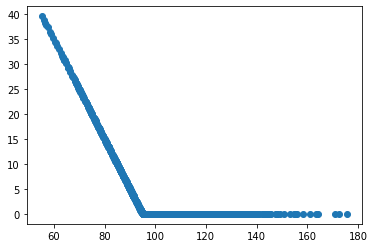

In [82]:
plt.scatter(X_train, Y_train)

In [83]:
nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), batch_size=1, epochs=30, verbose=1)

Epoch 1/30
1000/1000 [==============================] - 1s 1ms/step - loss: 125.3177
Epoch 2/30
1000/1000 [==============================] - 1s 1ms/step - loss: 87.1234
Epoch 3/30
1000/1000 [==============================] - 1s 1ms/step - loss: 76.4862
Epoch 4/30
1000/1000 [==============================] - 1s 1ms/step - loss: 70.3412
Epoch 5/30
1000/1000 [==============================] - 1s 1ms/step - loss: 59.6199
Epoch 6/30
1000/1000 [==============================] - 1s 1ms/step - loss: 49.4256
Epoch 7/30
1000/1000 [==============================] - 2s 2ms/step - loss: 44.2084
Epoch 8/30
1000/1000 [==============================] - 1s 1ms/step - loss: 40.5902
Epoch 9/30
1000/1000 [==============================] - 1s 1ms/step - loss: 39.0326
Epoch 10/30
1000/1000 [==============================] - 1s 1ms/step - loss: 33.1076
Epoch 11/30
1000/1000 [==============================] - 1s 1ms/step - loss: 34.8066
Epoch 12/30
1000/1000 [==============================] - 1s 1ms/step - lo

In [84]:
inner_weights = nn.layers[0].get_weights()[0]
strikes = nn.layers[0].get_weights()[1]

In [85]:
strikes

array([  0.      , -10.224838, -13.193678,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,  16.314362,  10.789741],
      dtype=float32)

In [86]:
inner_weights

array([[-0.77033293,  0.50239724,  0.05963617, -1.0324123 , -1.4355276 ,
        -0.9924187 , -1.7294081 , -0.9784094 , -0.214533  , -0.20016941]],
      dtype=float32)

In [87]:
S = np.arange(0,120)
V = np.zeros(S.shape)

V = nn.predict(np.array(S).reshape(-1,1))

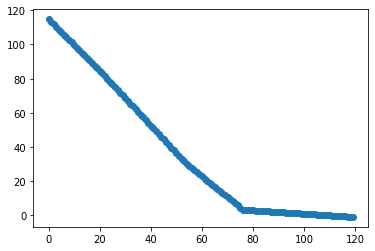

In [88]:
plt.scatter(S,V)

In [26]:
dates = [0,24,49,74, 99]
dates.reverse()

In [265]:
nf = neural_bermudan_fitter(r, sigma, s_all,  100, dates, epochs = 30)

In [266]:
nf.run_pricing_simulation()

Epoch 1/30
1000/1000 [==============================] - 2s 1ms/step - loss: 156.6015
Epoch 2/30
1000/1000 [==============================] - 1s 1ms/step - loss: 137.2102
Epoch 3/30
1000/1000 [==============================] - 1s 1ms/step - loss: 134.7025
Epoch 4/30
1000/1000 [==============================] - 1s 1ms/step - loss: 131.0708
Epoch 5/30
1000/1000 [==============================] - 1s 1ms/step - loss: 127.9036
Epoch 6/30
1000/1000 [==============================] - 1s 1ms/step - loss: 124.9545
Epoch 7/30
1000/1000 [==============================] - 1s 1ms/step - loss: 121.5603
Epoch 8/30
1000/1000 [==============================] - 1s 1ms/step - loss: 117.8790
Epoch 9/30
1000/1000 [==============================] - 1s 1ms/step - loss: 118.6661
Epoch 10/30
1000/1000 [==============================] - 1s 1ms/step - loss: 115.5072
Epoch 11/30
1000/1000 [==============================] - 1s 1ms/step - loss: 110.5341
Epoch 12/30
1000/1000 [==============================] - 1s 1ms

KeyboardInterrupt: 

In [260]:
for s in S:
    V[s] = nf.nnets[0].predict(np.array(s).reshape(-1,1))

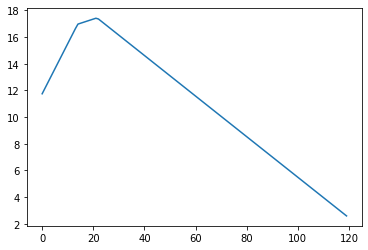

In [261]:
plt.plot(S,V)

In [211]:
for s in S:
    V[s] = nf.nnets[1].predict(np.array(s).reshape(-1,1))

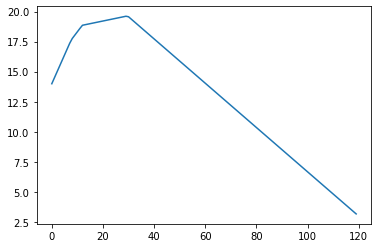

In [212]:
plt.plot(S,V)

In [150]:
inner_weights = nf.nnets[0].layers[0].get_weights()[0]
strikes = nf.nnets[0].layers[0].get_weights()[1]

In [151]:
strikes

array([  0.        ,   0.        ,  -0.09036612, -11.239232  ,
        13.6291065 ,  10.585274  ,   0.        ,   0.        ,
         0.        ,   0.        ], dtype=float32)

In [152]:
inner_weights

array([[-0.46909952, -0.30710685, -0.0643453 ,  0.25358894, -0.14093241,
        -0.10899258, -0.45356843, -0.42138857, -0.4258882 , -0.31847745]],
      dtype=float32)